In [1]:
import kagglehub
package = kagglehub.package_import('ryanholbrook/drawing-with-llms-getting-started-with-gemma-2/versions/9')

/home/omichi/anaconda3/envs/svgllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installing python dependencies for Package 'kagglehub_package_ryanholbrook_drawing_with_llms_getting_started_with_gemma_2_9', logging progress to '/tmp/kagglehub-package-dependencies-install-ck3z96yj.txt'.


In [ ]:
#| default_exp core

In [ ]:
#| export
import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):
         # Quantization Configuration
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.model_path = kagglehub.model_download('google/gemma-2/Transformers/gemma-2-9b-it/2')
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_path,
            device_map={"": 0},
            quantization_config=quantization_config,
        )
        self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 90

    # You could try increasing `max_new_tokens`
    def predict(self, description: str, max_new_tokens=512) -> str:
        def generate_svg():
            try:
                prompt = self.prompt_template.format(description)
                inputs = self.tokenizer(text=prompt, return_tensors="pt").to(DEVICE)

                with torch.no_grad():
                    output = self.model.generate(
                        **inputs,
                        max_new_tokens=max_new_tokens,
                        do_sample=True,
                    )

                output_decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
                logging.debug('Output decoded from model: %s', output_decoded)

                matches = re.findall(r"<svg.*?</svg>", output_decoded, re.DOTALL | re.IGNORECASE)
                if matches:
                    svg = matches[-1]
                else:
                    return self.default_svg

                logging.debug('Unprocessed SVG: %s', svg)
                svg = self.enforce_constraints(svg)
                logging.debug('Processed SVG: %s', svg)
                # Ensure the generated code can be converted by cairosvg
                cairosvg.svg2png(bytestring=svg.encode('utf-8'))
                return svg
            except Exception as e:
                logging.error('Exception during SVG generation: %s', e)
                return self.default_svg

        # Execute SVG generation in a new thread to enforce time constraints
        with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
            future = executor.submit(generate_svg)
            try:
                return future.result(timeout=self.timeout_seconds)
            except concurrent.futures.TimeoutError:
                logging.warning("Prediction timed out after %s seconds.", self.timeout_seconds)
                return self.default_svg
            except Exception as e:
                logging.error(f"An unexpected error occurred: {e}")
                return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


DEBUG:bitsandbytes.cextension:Loading bitsandbytes native library from: /home/omichi/anaconda3/envs/svgllm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda124.so
INFO:accelerate.utils.modeling:Based on the current allocation process, no modules could be assigned to the following devices due to insufficient memory:
  - 0: 1934105600.0 bytes required
  - 1: 1835008000 bytes required
  - 2: 1835008000 bytes required
These minimum requirements are specific to this allocation attempt and may vary. Consider increasing the available memory for these devices to at least the specified minimum, or adjusting the model config.
Loading checkpoint shards: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]
ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'a purple forest at d...': 0.1283 seconds


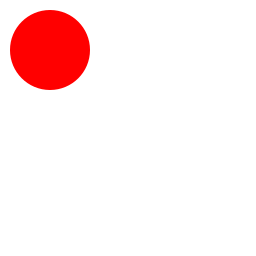

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'gray wool coat with ...': 0.0094 seconds


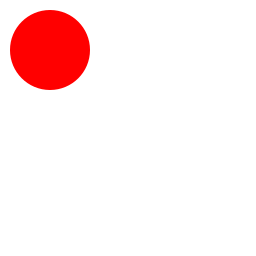

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'a lighthouse overloo...': 0.0074 seconds


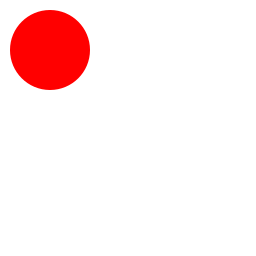

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'burgundy corduroy pa...': 0.0077 seconds


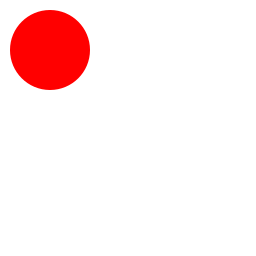

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'orange corduroy over...': 0.0049 seconds


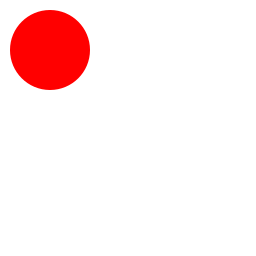

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'a purple silk scarf ...': 0.0044 seconds


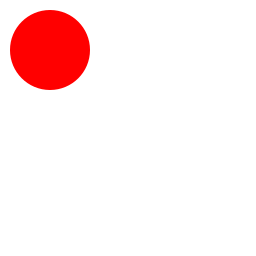

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'a green lagoon under...': 0.0043 seconds


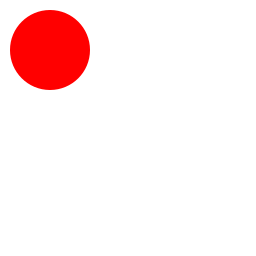

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'crimson rectangles f...': 0.0044 seconds


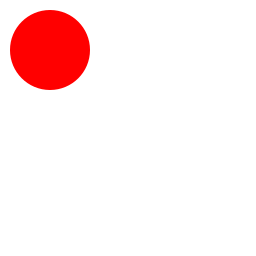

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'purple pyramids spir...': 0.0049 seconds


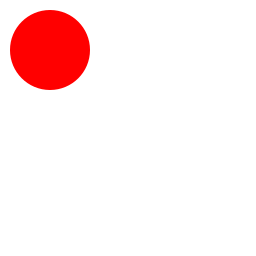

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'magenta trapezoids l...': 0.0050 seconds


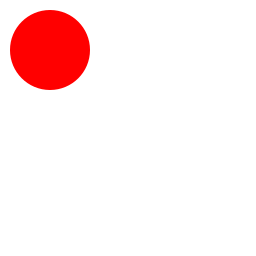

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'a snowy plain...': 0.0049 seconds


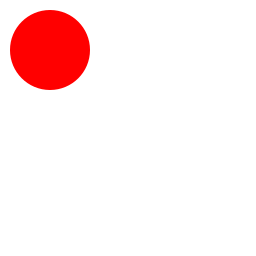

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'black and white chec...': 0.0039 seconds


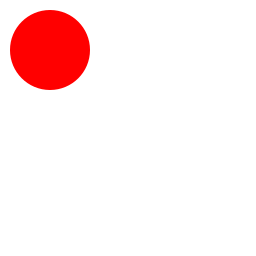

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'a starlit night over...': 0.0038 seconds


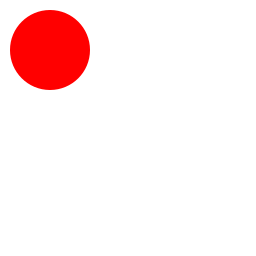

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'khaki triangles and ...': 0.0046 seconds


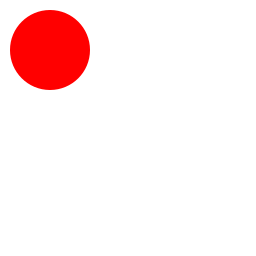

ERROR:root:Exception during SVG generation: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)


Prediction time for description 'a maroon dodecahedro...': 0.0046 seconds


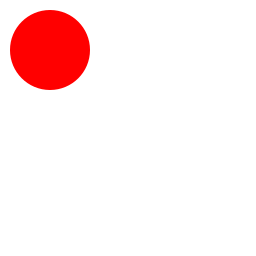

In [4]:
def generate():
    import polars as pl
    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.DEBUG, force=True)
    
    train = pl.read_csv('train.csv')
    display(train.head())
    
    model = Model()
    svgs = []
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
    
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

# Uncomment and run the line below to see some generated images
generate()

In [24]:
import kaggle_evaluation

logging.basicConfig(level=logging.INFO, force=True)
kaggle_evaluation.test(Model)

AttributeError: partially initialized module 'kaggle_evaluation' has no attribute 'core' (most likely due to a circular import)